# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from numpy import where
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_regression
from sklearn.tree import ExtraTreeRegressor
import math as m
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVC, SVC, LinearSVR
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [242]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)
y = y.drop(columns=['id'])

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Handling outliers

### Handling missing values 

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [244]:
y_test = y_test.fillna(y_test.median())
y_train = y_train.fillna(y_train.median())
X_test = X_test.fillna(X_test.median())

X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

## compute the ration of missing values ?


In [197]:
# scaler = MinMaxScaler()
# scaler.fit(X_train_filled)
# X_train_norm = scaler.transform(X_train_filled)
# X_test_norm = scaler.transform(X_test_filled)

In [245]:
scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)

### Handling feature selections

In [246]:
## Univariate feature selection with the highest variance
select_feature = SelectKBest(f_regression, k=(160)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [247]:
## Feature selection with PCA

pca = PCA(n_components=200)
pca.fit(X_train_norm,y_train)
X_train_pca = pca.transform(X_train_norm)
X_test_pca= pca.transform(X_test_norm)

## Feature selection/ranking with recursive feature elimination


clf_rf_4 = LinearRegression()
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='r2')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_norm, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train_norm.columns[rfecv.support_])

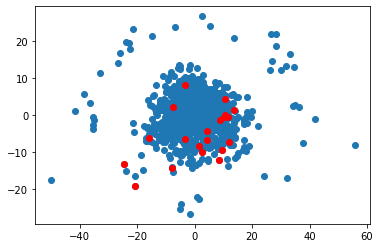

(20, 200) (969, 200)


(array([  0, 199, 236, 298, 395, 505, 507, 509, 518, 557, 558, 626, 639,
        717, 793, 799, 869, 882, 886, 920]),)

In [236]:
## Outlier detection with multivariate technique: gaussian mixture model
elenv = EllipticEnvelope(contamination=0.02)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

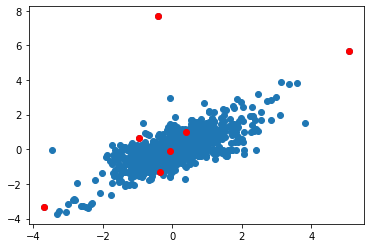

(7, 160) (969, 160)


(array([483, 518, 558, 626, 728, 821, 836]),)

In [248]:
## Outlier detection with multivariate technique: LOF
elenv = LocalOutlierFactor(n_neighbors=20)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

In [ ]:
X_anom_dtf = pd.DataFrame(values_anom)
sns.set()
sns.pairplot(X_dtf, size = 2.5)
sns.pairplot(X_anom_dtf, size = 2.5)
plt.show();

In [249]:
## What do you with outliers
# 1/ just trying to drop them

X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

(962, 160) (962, 1)


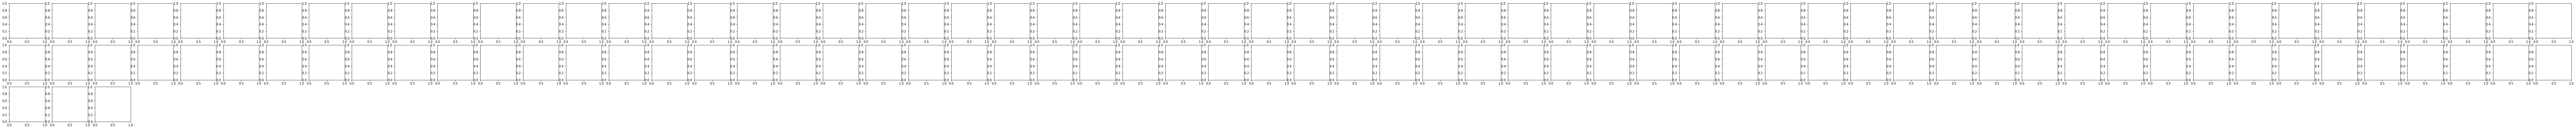

In [221]:
X_pd_final = pd.DataFrame(X_train_less_outliers)
sns.pairplot(X_pd_final, size = 2.5)

In [250]:
model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)

score

0.25715475502870444

In [251]:
model = Ridge(alpha=1000)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.3533247116330128

In [252]:
model = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5918403847955049

In [253]:
model =GradientBoostingRegressor(random_state=0)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5313216790838187

In [254]:
model =ExtraTreesRegressor()
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_2483/1356825632.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_less_outliers, Y_train_less_outliers)


0.5345177287556787

In [255]:
## RFD with normalized data

regr = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
regr.fit(X_train_new, y_train)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_2483/529011428.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_new, y_train)


0.5379165091319327

In [256]:
## RFD with normalize data and without outliers

regr = RandomForestRegressor(max_depth=None, random_state=0)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score


/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_2483/2536698496.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_less_outliers, Y_train_less_outliers)


0.5410559990243009

In [257]:
kernel = DotProduct() + WhiteKernel()
regr = GaussianProcessRegressor(kernel=kernel,random_state=0)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

0.3175137647753835

In [258]:
r1 = GradientBoostingRegressor(random_state=0)
r2 = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = RandomForestRegressor(max_depth=20, random_state=0)
r4 = ExtraTreesRegressor()
regr = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('abr', r4)], weights=[2,3,1,1],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5956049380270849

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [184]:
## Final training for submit

X = pd.read_csv('X_train.csv')
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530', 'id']
X_train_final = X.drop(columns=to_drop)
X_test_final = Xt.drop(columns=to_drop)
y_train_final = y.drop(columns=['id']) 

In [185]:
y_train = y_train_final.fillna(y_train_final.median())
X_train_filled = X_train_final.fillna(X_train_final.median())
X_test_filled = X_test_final.fillna(X_test_final.median())

scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)
print(X_train_norm.shape,X_test_norm.shape)

(1212, 828) (776, 828)


In [186]:
select_feature = SelectKBest(f_regression, k=(160)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
print(X_train_new.shape,X_test_new.shape)

(1212, 160) (776, 160)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


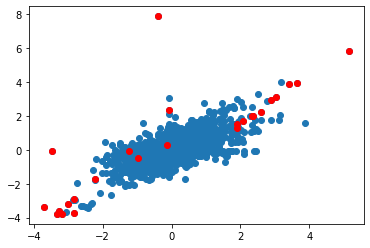

(25, 160) (1212, 160)


In [187]:
elenv = EllipticEnvelope(contamination=0.02)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index
X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)

In [188]:
r1 = GradientBoostingRegressor(random_state=0)
r2 = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = RandomForestRegressor(max_depth=20, random_state=0)
r4 = ExtraTreesRegressor()
regr = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('abr', r4)], weights=[2,3,1,1],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [189]:
y_pred.shape

(776,)

In [190]:
pd.DataFrame({'id': [float(i) for i in range(y_pred.size)], 'y': y_pred}).to_csv('Prediction.csv')